In [305]:
import xarray as xr
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [306]:
# Determine the device to use
cpu = True
if torch.cuda.is_available() and not cpu:
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available() and not cpu:
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using CPU device


In [307]:
# Loading and combining datasets
path = "./data"
nc_files = glob.glob(os.path.join(path, "*.nc"))

datasets = [xr.open_dataset(f, engine='netcdf4') for f in nc_files]

combined_ds = xr.concat(datasets, dim='time')

In [308]:
# Defining the config and hyperparameters
config = {
    'time_step': 1,
    'batch_size': 32,
    'num_epochs': 20,
    'learning_rate': 1e-4,
    'test_size': 0.2,
}

In [309]:
# Standardize the data
mean_tas = combined_ds.tas.mean(dim='time', skipna=True)
std_tas = combined_ds.tas.std(dim='time', skipna=True)

standardized_tas = (combined_ds.tas - mean_tas) / std_tas

time_index = 0
standardized_tas_slice = standardized_tas.isel(time=time_index)

In [310]:
# # Fill nan values with 0s
filled_standardized_tas = standardized_tas.fillna(0)
filled_standardized_tas = combined_ds.tas.fillna(0)

data = filled_standardized_tas.values.astype(np.float32)

data_shape = data.shape

if len(data_shape) < 2:
    raise ValueError("Data must have at least two dimensions for x and y.")

x_dim = data_shape[-2]
y_dim = data_shape[-1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_data = np.pad(data, ((0, 0),) * (len(data_shape) - 2) + ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_data = np.expand_dims(padded_data, axis=1)
expanded_data.shape

(600, 1, 56, 56)

In [311]:
# Create a dataset to serve the data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, time_step=1):
        self.time_step = time_step
        self.data = data

    def __len__(self):
        return len(self.data) - self.time_step * 2

    def __getitem__(self, idx):
        return np.concatenate((self.data[idx], self.data[idx+self.time_step]), axis=0), self.data[idx+self.time_step*2]

dataset = TimeSeriesDataset(expanded_data)

In [312]:
# Split into test and train datasets
test_size = int(len(dataset) * config['test_size'])
train_size = len(dataset) - test_size 

indices = np.arange(len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

In [313]:
# Define model
class CNNTimeSeriesForecast(nn.Module):
    def __init__(self, input_size, mlp_expand_size=4):
        super(CNNTimeSeriesForecast, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_size[0], 16, kernel_size=(3,3), stride=2, padding=(1, 1)),
            # nn.BatchNorm2d(16),
            # nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=2, padding=1),
            # nn.BatchNorm2d(32),
            # nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=2, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ReLU()
        )

        self.flattened_size = self._get_flattened_size(input_size)

        self.mlp = nn.Sequential(
            nn.Linear(self.flattened_size, self.flattened_size * mlp_expand_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.flattened_size * mlp_expand_size, self.flattened_size),
        )

        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose1 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.activation = nn.ReLU()

    def _get_flattened_size(self, input_size):
        dummy_input = torch.zeros(2, *input_size)
        with torch.no_grad():
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.view(x.size(0), -1).size(1)
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        x_batch, x_channel, x_height, x_width = x3.shape
        x = x3.view(x3.size(0), -1)
        x = self.mlp(x)
        x = x.reshape(x_batch, x_channel, x_height, x_width)

        x = x + x3
        x = self.activation(self.conv_transpose3(x))
        x = x + x2  
        x = self.activation(self.conv_transpose2(x))
        x = x + x1  
        x = self.conv_transpose1(x)

        return x

dummy_input= next(iter(test_loader))[0]
model = CNNTimeSeriesForecast(input_size=dummy_input[0].shape).to(device)

model(dummy_input).shape

torch.Size([32, 1, 56, 56])

In [314]:
# Create a mask over the non-null values
non_null_mask = combined_ds.tas.notnull()
collapsed_mask = np.all(non_null_mask.values, axis=0)

mask_shape = collapsed_mask.shape
x_dim = mask_shape[0]
y_dim = mask_shape[1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_mask = np.expand_dims(padded_mask, axis=0)

batch_size = config['batch_size']
batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

mask_tensor = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
mask_tensor.shape

torch.Size([32, 1, 56, 56])

In [315]:
# Training set up
criterion = nn.MSELoss(reduction='none')  
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [316]:
# Training loop
for epoch in range(config['num_epochs']):
    model.train()  
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']-1}", leave=False)
    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)

        # Apply the mask to the outputs and labels
        masked_loss = criterion(outputs, labels) * mask_tensor
        loss = masked_loss.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Train Loss': loss.item()})

    train_loss /= len(train_loader)

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            # Apply the mask to the outputs and labels
            masked_loss = criterion(outputs, labels) * mask_tensor
            loss = masked_loss.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch [{epoch}/{config['num_epochs']-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [0/14], Train Loss: 126.2709, Test Loss: 109.7233


Epoch [1/14], Train Loss: 94.6229, Test Loss: 77.3137


Epoch [2/14], Train Loss: 62.6012, Test Loss: 49.4908


Epoch [3/14], Train Loss: 38.4634, Test Loss: 29.5635


Epoch [4/14], Train Loss: 22.8460, Test Loss: 17.6551


Epoch [5/14], Train Loss: 13.8660, Test Loss: 11.7399


Epoch [6/14], Train Loss: 9.7164, Test Loss: 9.0160


Epoch [7/14], Train Loss: 7.7789, Test Loss: 7.5743


Epoch [8/14], Train Loss: 6.6301, Test Loss: 6.7046


Epoch [9/14], Train Loss: 5.7657, Test Loss: 6.2041


Epoch [10/14], Train Loss: 5.4159, Test Loss: 5.8946


Epoch [11/14], Train Loss: 5.0181, Test Loss: 5.7537


Epoch [12/14], Train Loss: 4.8136, Test Loss: 5.5068


Epoch [13/14], Train Loss: 4.8768, Test Loss: 5.3807


Epoch [14/14], Train Loss: 4.4500, Test Loss: 5.1411


In [317]:
# Run the model on one example
features, labels = next(iter(test_loader))
features, labels = features.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(features)

features = features.cpu().numpy()
labels = labels.cpu().numpy()
outputs = outputs.cpu().numpy()
mask = mask_tensor.cpu().numpy()

masked_output = outputs * mask

difference = labels - masked_output

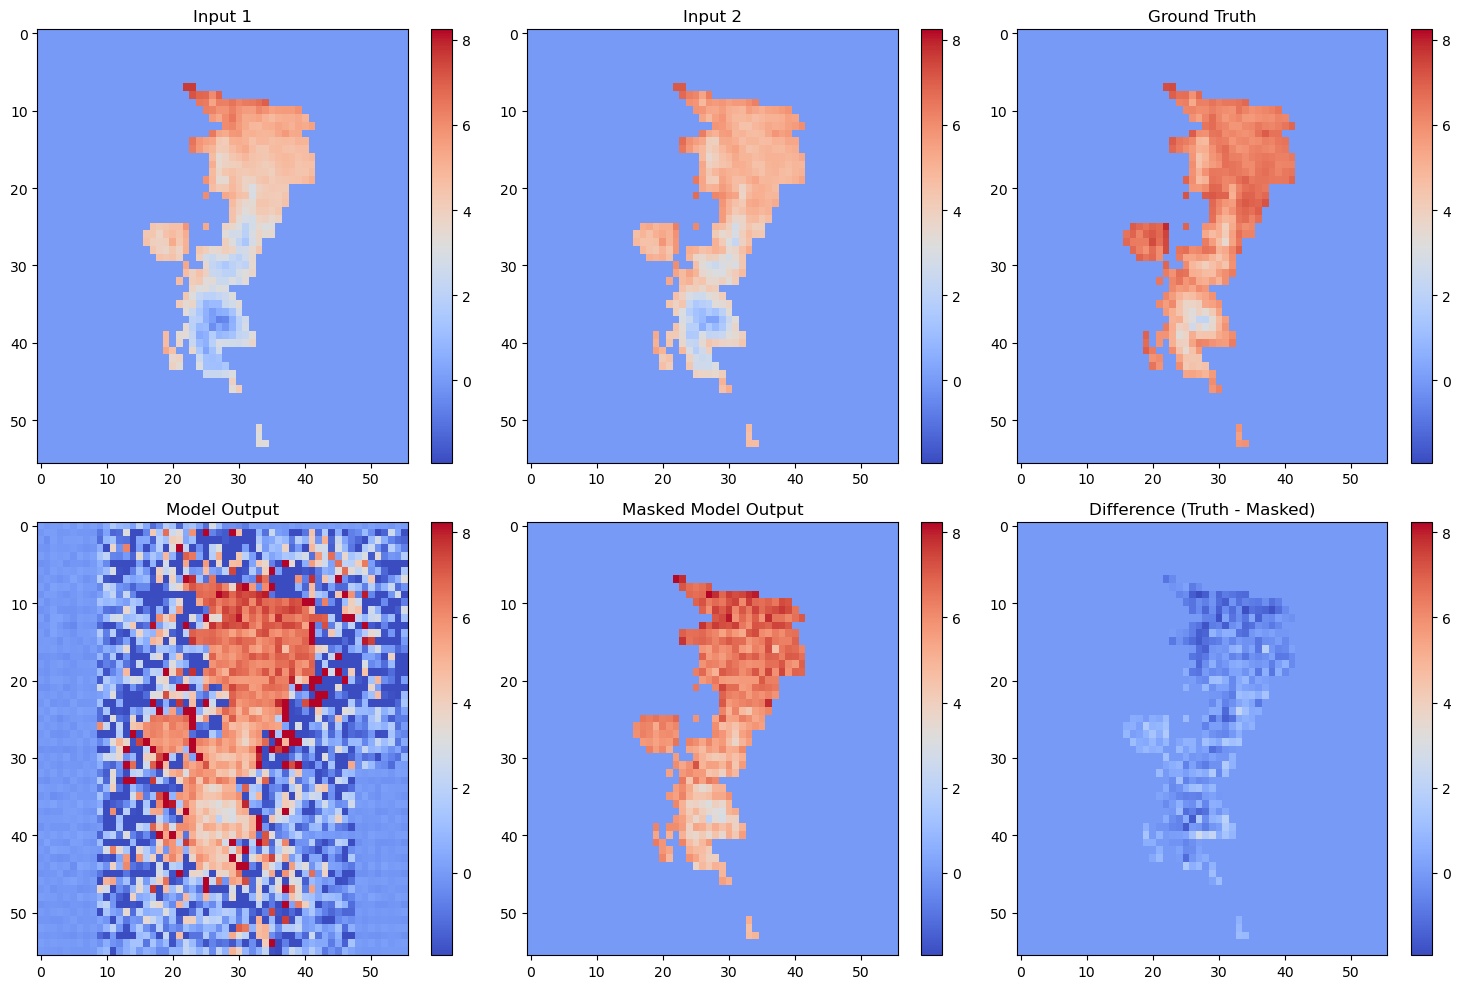

In [335]:
# Visualise the input and output data
sample_index = 0
vmin = min(features[sample_index].min(), labels[sample_index].min(), masked_output[sample_index].min(), difference[sample_index].min())
vmax = max(features[sample_index].max(), labels[sample_index].max(), masked_output[sample_index].max(), difference[sample_index].max())

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(features[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 1')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(features[sample_index, 1], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 2')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(labels[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.colorbar()

# Plot model outputs, masked outputs, and difference on the second row
plt.subplot(2, 3, 4)
plt.imshow(outputs[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Model Output')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(masked_output[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Masked Model Output')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(difference[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Difference (Truth - Masked)')
plt.colorbar()

plt.tight_layout()
plt.show()